<a href="https://colab.research.google.com/github/matanb1238/EmotionClassifier/blob/main/notebooks/svm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion Classification from Tweets
University Machine Learning Project  
**Authors**: [Your Name], [Partner's Name]  
**Dataset**: [Emotions Dataset - Twitter, ~400K rows]  
**Goal**: Understand and classify emotional content in tweets

## Table of Contents
1. [Dataset Overview](#dataset-overview)
2. [Data Cleaning](#data-cleaning)
3. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis)
4. [Feature Extraction: TF-IDF](#feature-extraction)
5. [Model 1: Support Vector Machine (SVM)](#svm)
6. [Model Comparison](#model-comparison)
7. [Conclusion and Discussion](#conclusion)


## 1. Dataset Overview <a name="dataset-overview"></a>

In this section, we load the dataset and explore its basic structure.  
We check column names, sample entries, and class distribution.

In [8]:
import pandas as pd

# File load
df = pd.read_csv('text.csv')

# Checking rows count and the head
print(f"Rows count: {len(df)}")
df.head()

Rows count: 416809


,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


## 2. Data Cleaning <a name="data-cleaning"></a>

We remove missing values and empty texts to prepare the data for analysis.  
This ensures that our models will not be affected by noise or null inputs.

In [10]:
# Check if column names are correct
print("Columns:", df.columns)

# Check for missing values in the dataset
print("Missing values per column:")
print(df.isnull().sum())

# Remove rows with missing values
df = df.dropna()

# Remove empty texts (even if not NaN)
df = df[df['text'].str.strip() != '']

# Show new shape after cleaning
print(f"Dataset shape after cleaning: {df.shape}")

Columns: Index(['Unnamed: 0', 'text', 'label'], dtype='object')
Missing values per column:
Unnamed: 0    0
text          0
label         0
dtype: int64
Dataset shape after cleaning: (416809, 3)


## 3. Exploratory Data Analysis (EDA) <a name="exploratory-data-analysis"></a>

Here we examine:
- Class distribution
- Most common words per emotion
- Confusing emotions
- Tweet length distribution per emotion

We visualize relevant insights using bar charts, box plots, and word clouds.

In [14]:
# Define label-to-emotion mapping based on known dataset structure
label_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

# Create a new column with emotion names instead of numeric labels
df['emotion'] = df['label'].map(label_map)

# Preview the mapping to make sure it worked
print(df[['label', 'emotion']].head())

   label  emotion
0      4     fear
1      0  sadness
2      4     fear
3      0  sadness
4      4     fear


/tmp/ipython-input-15-1734356921.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="Set2")


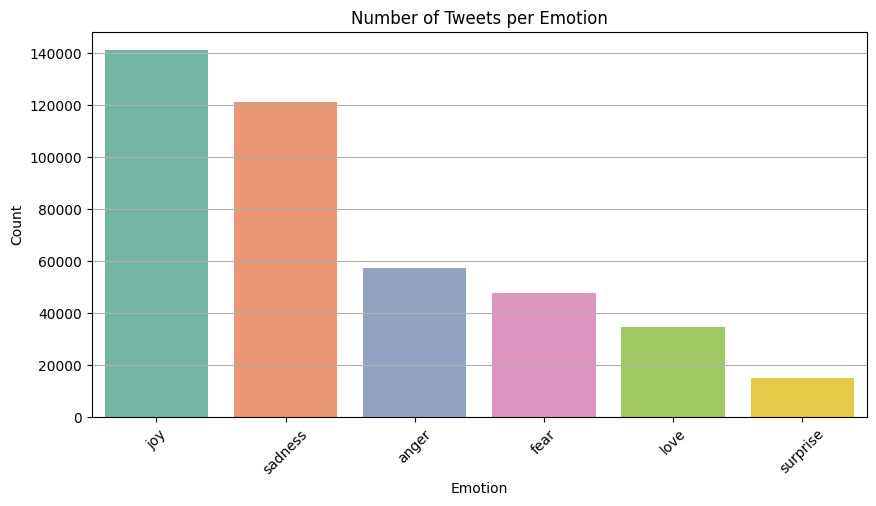

/tmp/ipython-input-15-1734356921.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='emotion', y='text_length', data=df, palette="Set3")


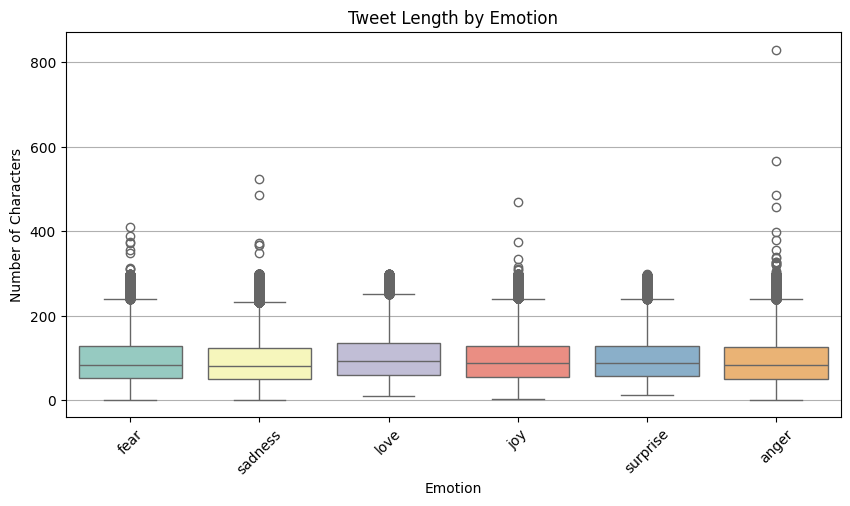

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the number of examples per emotion
emotion_counts = df['emotion'].value_counts()

# Plot a bar chart of emotion distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="Set2")
plt.title("Number of Tweets per Emotion")
plt.ylabel("Count")
plt.xlabel("Emotion")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Add a new column for text length
df['text_length'] = df['text'].apply(len)

# Plot a boxplot of tweet length per emotion
plt.figure(figsize=(10, 5))
sns.boxplot(x='emotion', y='text_length', data=df, palette="Set3")
plt.title("Tweet Length by Emotion")
plt.ylabel("Number of Characters")
plt.xlabel("Emotion")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


## 4. Feature Extraction: TF-IDF <a name="feature-extraction"></a>

We transform the text into numerical vectors using TF-IDF,  
which captures term importance across the dataset.

## 5. Model 1: Support Vector Machine (SVM) <a name="svm"></a>

We train an SVM classifier using the TF-IDF features.  
We evaluate performance using classification metrics and a confusion matrix.

## 6. Model Comparison <a name="model-comparison"></a>

We compare the models using:
- Accuracy
- F1-score (macro & weighted)
- Confusion matrices
- Training time (optional)

## 7. Conclusion and Discussion <a name="conclusion"></a>

We reflect on:
- What worked well
- What didn’t work
- Why some emotions were harder to classify
- Challenges during the project
- Ideas for improvement or future work